In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

***

# Exploration of potential bias

In [203]:
PV_data = pd.read_csv('./data/police_violence.csv', index_col=0)
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,victim_fleeing
0,66.0,Male,hispanic,2020,Tyler,TX,Gunshot,No known charges,Allegedly Armed,unknown weapon,not fleeing
1,42.0,Male,unknown race,2020,Hart County,KY,Gunshot,No known charges,Allegedly Armed,gun,other
2,28.0,Male,white,2020,St. Augustine,FL,Gunshot,No known charges,Allegedly Armed,gun,NaN
3,39.0,Male,unknown race,2020,La Vergne,TN,Gunshot,No known charges,Allegedly Armed,gun,car
4,32.0,Male,unknown race,2020,Batesville,IN,Gunshot,No known charges,Allegedly Armed,gun,not fleeing


In [204]:
races = ["white", "black", "hispanic"]

### Race bias in criminal charges:

In [205]:
charged_percts = [] #charged percentages
for race in races:
    df = PV_data.query('victim_race == @race')
    count = df.groupby('criminal_charges').count()
    total = len(df)
    charged = count.loc['Charged':'Charged', 'State'][0] #we use the column `State` to do the slicing because it has zero NaN values,
    
    charged_percent = np.around(charged / total * 100)
    charged_percts.append(charged_percent)
    print("Percentage of police being charged in case of a %s victim: %4.2f"%(race, charged_percent))

Percentage of police being charged in case of a white victim: 1.00
Percentage of police being charged in case of a black victim: 3.00
Percentage of police being charged in case of a hispanic victim: 1.00


### Race bias in killing the victim is unarmed (or unclear):

In [206]:
df = PV_data.query('victim_race == "black"')
df.groupby('victim_armed').count()

,victim_age,victim_gender,victim_race,date,City,State,cause_of_death,criminal_charges,alleged_weapon,victim_fleeing
victim_armed,,,,,,,,,,
Allegedly Armed,1445,1464,1464,1464,1464,1464,1464,1464,1464,1027
Unarmed,363,364,364,364,364,364,364,364,364,196
Unclear,162,164,164,164,164,164,164,164,164,86
Vehicle,165,166,166,166,166,166,166,166,166,113


In [207]:
unarmed_percts = [] #percentages of being killed while unarmed
for race in races:
    df = PV_data.query('victim_race == @race')
    total = len(df)
    count = df.groupby('victim_armed').count()
    unarmed = count.loc['Unarmed':'Unarmed', 'State'][0] #we use the column `State` to do the slicing because it has zero NaN values,
    unclear = count.loc['Unclear':'Unclear', 'State'][0] #so we are sure the count is correct.

    killing_percent = np.around((unarmed+unclear) / total * 100)
    unarmed_percts.append(killing_percent)
    print("Percentage of being killed while unarmed in case of a %s victim: %4.2f"%(race, killing_percent))

Percentage of being killed while unarmed in case of a white victim: 20.00
Percentage of being killed while unarmed in case of a black victim: 24.00
Percentage of being killed while unarmed in case of a hispanic victim: 25.00


### Race bias in killing based on victim fleeing or not:

In [208]:
not_fleeing_percts = [] #percentages of being killed while not fleeing
for race in races:
    df = PV_data.query('victim_race == @race')
    total = len(df)
    count = df.groupby('victim_fleeing').count()
    not_fleeing = count.loc['not fleeing':'not fleeing', 'State'][0] #we use the column `State` to do the slicing because it has zero NaN values

    killing_percent = np.around(not_fleeing / total * 100, decimals=1)
    not_fleeing_percts.append(killing_percent)
    print("Percentage of being killed while not fleeing in case of a %s victim: %f"%(race, killing_percent))

Percentage of being killed while not fleeing in case of a white victim: 48.400000
Percentage of being killed while not fleeing in case of a black victim: 40.100000
Percentage of being killed while not fleeing in case of a hispanic victim: 43.200000


### Distribution of races among victims armed with at least a gun:

In [209]:
df_guns = PV_data.query('alleged_weapon == "gun"')
total = len(df_guns)

In [210]:
count_guns_by_race = df_guns.groupby('victim_race').count()

for race in races:
    c = count_guns_by_race.loc[race:race, 'State'][0]
    prct = c/total * 100
    print("Percentage of %s among victims carrying a gun: %f"%(race, prct))

Percentage of white among victims carrying a gun: 45.674967
Percentage of black among victims carrying a gun: 25.425950
Percentage of hispanic among victims carrying a gun: 14.635212


### Distribution of states among victims carrying a gun:

In [213]:
count_guns_by_state = df_guns.groupby('State').count()
states = df_guns.State.unique()

In [219]:
count_by_state = df_guns.groupby('State').count()
guns_by_state = dict({})
print("Distribution of states among victims carrying guns:")

for state in states:
    c = count_guns_by_state.loc[state:state, 'victim_race'][0]
    #prct = np.around(c/total * 100, decimals=2)
    guns_by_state[state] = c
    print("%s : %d"%(state, c))

Distribution of states among victims carrying guns:
KY : 84
FL : 338
TN : 111
IN : 95
CA : 526
TX : 449
OH : 125
MS : 64
PA : 103
VA : 74
OK : 119
AZ : 213
MD : 65
WA : 124
GA : 162
CO : 167
MI : 84
IL : 116
NV : 86
UT : 48
WI : 69
MO : 149
AK : 29
NM : 100
AL : 87
SD : 15
LA : 91
MT : 30
SC : 84
MN : 48
NY : 76
NC : 152
KS : 46
IA : 27
DC : 16
ID : 37
AR : 68
WY : 12
NJ : 44
OR : 72
ME : 21
NE : 18
MA : 26
CT : 14
ND : 7
WV : 45
HI : 13
DE : 12
VT : 5
NH : 8
RI : 4


In [220]:
max_key = max(states_dict, key=states_dict.get)
max_key

'CA'

In [221]:
min_key = min(states_dict, key=states_dict.get)
min_key

'RI'

### What is the percentage of carrying a gun in every state

In [223]:
df_states = PV_data.groupby('State').count()
victims_by_state = {}
for state in states:
    c = df_states.loc[state:state, 'victim_race'][0]
    victims_by_state[state] = c
victims_by_state

{'KY': 139,
 'FL': 629,
 'TN': 206,
 'IN': 146,
 'CA': 1329,
 'TX': 795,
 'OH': 231,
 'MS': 117,
 'PA': 189,
 'VA': 138,
 'OK': 239,
 'AZ': 384,
 'MD': 143,
 'WA': 250,
 'GA': 302,
 'CO': 269,
 'MI': 135,
 'IL': 194,
 'NV': 146,
 'UT': 97,
 'WI': 127,
 'MO': 229,
 'AK': 48,
 'NM': 161,
 'AL': 154,
 'SD': 27,
 'LA': 168,
 'MT': 49,
 'SC': 133,
 'MN': 92,
 'NY': 175,
 'NC': 236,
 'KS': 79,
 'IA': 52,
 'DC': 27,
 'ID': 53,
 'AR': 117,
 'WY': 22,
 'NJ': 113,
 'OR': 125,
 'ME': 34,
 'NE': 39,
 'MA': 60,
 'CT': 40,
 'ND': 14,
 'WV': 78,
 'HI': 39,
 'DE': 21,
 'VT': 13,
 'NH': 20,
 'RI': 6}

In [226]:
#percentage of victim carrying a gun (and not only another weapon) by state
prct_of_gun_by_state = {}
for state in states:
    prct_of_gun_by_state[state] = np.around(guns_by_state[state] / victims_by_state[state] * 100, decimals=2)

prct_of_gun_by_state

{'KY': 60.43,
 'FL': 53.74,
 'TN': 53.88,
 'IN': 65.07,
 'CA': 39.58,
 'TX': 56.48,
 'OH': 54.11,
 'MS': 54.7,
 'PA': 54.5,
 'VA': 53.62,
 'OK': 49.79,
 'AZ': 55.47,
 'MD': 45.45,
 'WA': 49.6,
 'GA': 53.64,
 'CO': 62.08,
 'MI': 62.22,
 'IL': 59.79,
 'NV': 58.9,
 'UT': 49.48,
 'WI': 54.33,
 'MO': 65.07,
 'AK': 60.42,
 'NM': 62.11,
 'AL': 56.49,
 'SD': 55.56,
 'LA': 54.17,
 'MT': 61.22,
 'SC': 63.16,
 'MN': 52.17,
 'NY': 43.43,
 'NC': 64.41,
 'KS': 58.23,
 'IA': 51.92,
 'DC': 59.26,
 'ID': 69.81,
 'AR': 58.12,
 'WY': 54.55,
 'NJ': 38.94,
 'OR': 57.6,
 'ME': 61.76,
 'NE': 46.15,
 'MA': 43.33,
 'CT': 35.0,
 'ND': 50.0,
 'WV': 57.69,
 'HI': 33.33,
 'DE': 57.14,
 'VT': 38.46,
 'NH': 40.0,
 'RI': 66.67}

In [228]:
max_key = max(prct_of_gun_by_state, key=prct_of_gun_by_state.get)
min_key = min(prct_of_gun_by_state, key=prct_of_gun_by_state.get)
min_key, max_key

('HI', 'ID')

# Plots

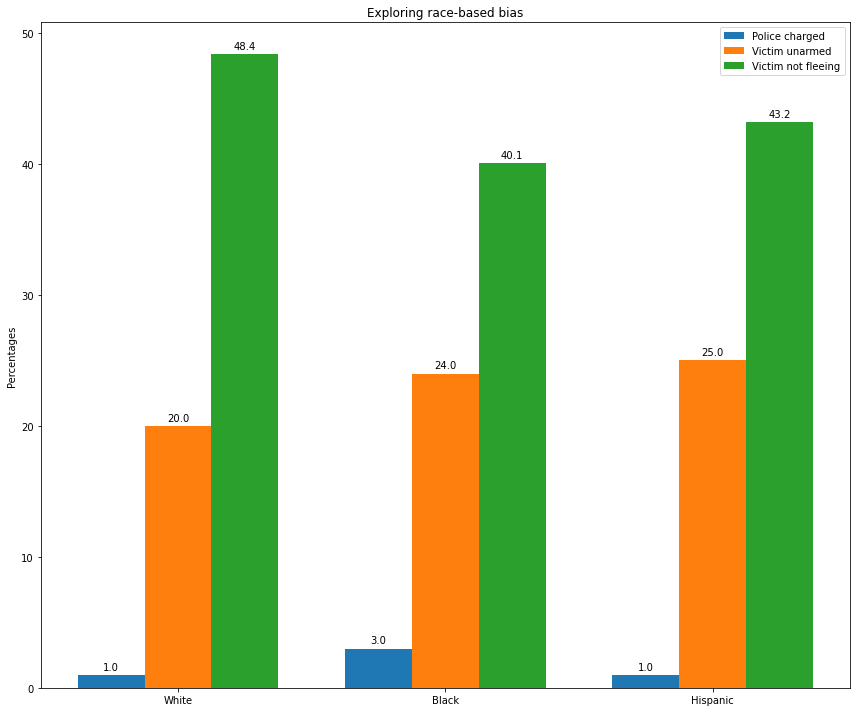

In [138]:
labels = ['White', 'Black', 'Hispanic']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

cat1 = ax.bar(x - width, charged_percts, width, label='Police charged')
cat2 = ax.bar(x, unarmed_percts, width, label='Victim unarmed')
cat3 = ax.bar(x + width, not_fleeing_percts, width, label='Victim not fleeing')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentages')
ax.set_title('Exploring race-based bias')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(cat1)
autolabel(cat2)
autolabel(cat3)

fig.tight_layout()

plt.show()